In [ ]:
Data Collection

In [57]:
import pandas as pd
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
from azure.core.exceptions import ServiceRequestError
import matplotlib.pyplot as plt

data = pd.read_csv("Reviews.csv")
data=data.head()
print(data)

def authenticate_client():
    key = "b4fe90ed47f647b5b95b90cf976db83f"
    endpoint = "https://staging-language-model.cognitiveservices.azure.com/"
    client = TextAnalyticsClient(endpoint=endpoint, credential=AzureKeyCredential(key))
    return client

client = authenticate_client()

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [ ]:
Data Preprocessing

In [58]:
import re
import string

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text) 
    text = text.strip()
    return text

processed_texts = data['Text'].apply(preprocess_text)

print(processed_texts[:5])

with open('processed_texts.txt', 'w', encoding='utf-8') as f:
    for text in processed_texts:
        f.write(text + '\n')

print("Processed texts saved to 'processed_texts.txt'")


0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price  there was a wide...
Name: Text, dtype: object
Processed texts saved to 'processed_texts.txt'


In [ ]:
Sentiment Analysis

In [62]:
def sentiment_analysis(client, documents):
    try:
        sentiments = {"positive": 0, "neutral": 0, "negative": 0, "mixed": 0}  # Add 'mixed'
        # Process in batches of 5
        for i in range(0, len(documents), 5):
            batch = documents[i:i+5]
            response = client.analyze_sentiment(documents=batch)
            for idx, doc in enumerate(response):
                print(f"Document {i + idx}: Sentiment - {doc.sentiment}")
                print(f"  Positive score: {doc.confidence_scores.positive}")
                print(f"  Neutral score: {doc.confidence_scores.neutral}")
                print(f"  Negative score: {doc.confidence_scores.negative}")
                sentiments[doc.sentiment] += 1
        return sentiments
    except ServiceRequestError as e:
        print(f"An error occurred during the sentiment analysis request: {str(e)}")
        return None
        
documents = data['Text'].tolist()
sentiments = sentiment_analysis(client, documents[:10])

Document 0: Sentiment - positive
  Positive score: 1.0
  Neutral score: 0.0
  Negative score: 0.0
Document 1: Sentiment - negative
  Positive score: 0.0
  Neutral score: 0.07
  Negative score: 0.93
Document 2: Sentiment - mixed
  Positive score: 0.5
  Neutral score: 0.02
  Negative score: 0.48
Document 3: Sentiment - positive
  Positive score: 1.0
  Neutral score: 0.0
  Negative score: 0.0
Document 4: Sentiment - positive
  Positive score: 0.91
  Neutral score: 0.08
  Negative score: 0.01


In [ ]:
Entity Recognition and Key Phrase Extraction

In [63]:
def entity_recognition(client, documents):
    try:
        # Process in batches of 5
        for i in range(0, len(documents), 5):
            batch = documents[i:i+5]
            response = client.recognize_entities(documents=batch)
            for idx, doc in enumerate(response):
                print(f"Document {i + idx}:")
                for entity in doc.entities:
                    print(f"  Entity: {entity.text}, Type: {entity.category}, Subtype: {entity.subcategory}")
    except ServiceRequestError as e:
        print(f"An error occurred during the entity recognition request: {str(e)}")

def key_phrase_extraction(client, documents):
    try:
        # Process in batches of 5
        for i in range(0, len(documents), 5):
            batch = documents[i:i+5]
            response = client.extract_key_phrases(documents=batch)
            for idx, doc in enumerate(response):
                print(f"Document {i + idx}: Key Phrases: {', '.join(doc.key_phrases)}")
    except ServiceRequestError as e:
        print(f"An error occurred during the key phrase extraction request: {str(e)}")
documents = data['Text'].tolist()
entity_recognition(client, documents[:10])
key_phrase_extraction(client, documents[:10])

Document 0:
  Entity: Vitality, Type: Organization, Subtype: Sports
  Entity: canned dog food products, Type: Product, Subtype: None
  Entity: stew, Type: Product, Subtype: None
  Entity: processed meat, Type: Product, Subtype: None
  Entity: product, Type: Product, Subtype: None
Document 1:
  Entity: Product, Type: Product, Subtype: None
  Entity: Jumbo Salted Peanuts, Type: Product, Subtype: None
  Entity: peanuts, Type: Product, Subtype: None
  Entity: vendor, Type: PersonType, Subtype: None
Document 2:
  Entity: confection, Type: Product, Subtype: None
  Entity: gelatin, Type: Product, Subtype: None
  Entity: Filberts, Type: Product, Subtype: None
  Entity: powdered sugar, Type: Product, Subtype: None
  Entity: heaven, Type: Location, Subtype: Structural
  Entity: C.S. Lewis, Type: Person, Subtype: None
  Entity: Edmund, Type: Person, Subtype: None
  Entity: Brother, Type: PersonType, Subtype: None
  Entity: Sisters, Type: PersonType, Subtype: None
  Entity: Witch, Type: PersonType

In [ ]:
Data Storage and Visualization

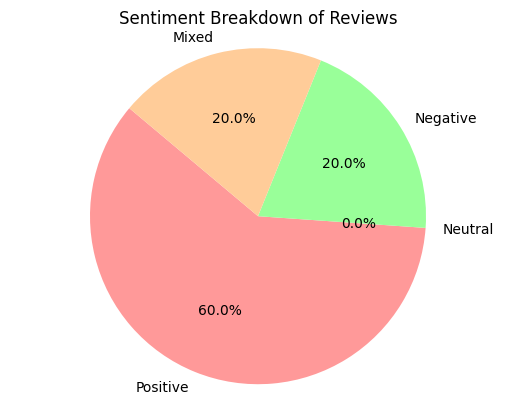

In [65]:
    import matplotlib.pyplot as plt
    def plot_sentiment_analysis(sentiments):
        labels = ['Positive', 'Neutral', 'Negative', 'Mixed']
        sizes = [sentiments['positive'], sentiments['neutral'], sentiments['negative'], sentiments['mixed']]
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')
        plt.title("Sentiment Breakdown of Reviews")
        plt.show()

    plot_sentiment_analysis(sentiments)


